## KrisFace GAN

Reimplementing a basic GAN with the fastai framework

In [99]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
import cv2
import numpy as np
from torchvision import transforms
from skimage import io, transform
# import tensorflow as tf

In [ ]:
path = pathlib.Path('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/krisFace_test1')
path_og = path/'original'
path_land = path/'landmarks'
path_og_lr = path/'original-96' #low res
path_og_mr = path/'original-256' #medium res
path_land_lr = path/'landmarks-96'
path_land_mr = path/'landmarks-256'

# Load Model

myFace-Generator-256b

In [5]:
src = ImageImageList.from_folder(path_land_lr).split_none() #(0.1, seed=42)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:171: UserWarning: `no_split` is deprecated, please use `split_none`.
  warn("`no_split` is deprecated, please use `split_none`.")


In [6]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_og_lr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(do_y=True))
    
    data.c = 3
    return data

In [7]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [8]:
base_loss = F.l1_loss

from torchvision.models import vgg16_bn
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False) #False means don't update weights and just use for loss

#MaxPool is the final activation fn in a layer
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [9]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [10]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,12])

In [11]:
bs, size = 6, 256
data = get_data(bs, size)

In [12]:
arch = models.resnet34

In [13]:
wd = 1e-3 #weight decay
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

#bs must correspond
learn.load('myFace-Generator-256a')
# learn.load('2d')
# learn.load('myFace-Generator-1c')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (540 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-96;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

Populating the interactive namespace from numpy and matplotlib


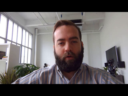

In [45]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data.y[4]

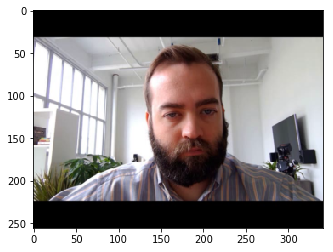

In [44]:
# img = mpimg.imread('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/4.png')
img = mpimg.imread('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/original-256/4.png')
imgplot = plt.imshow(img)
plt.show()

# Inference Exs
Model loaded to `learner`

In [14]:
gc.collect()

140

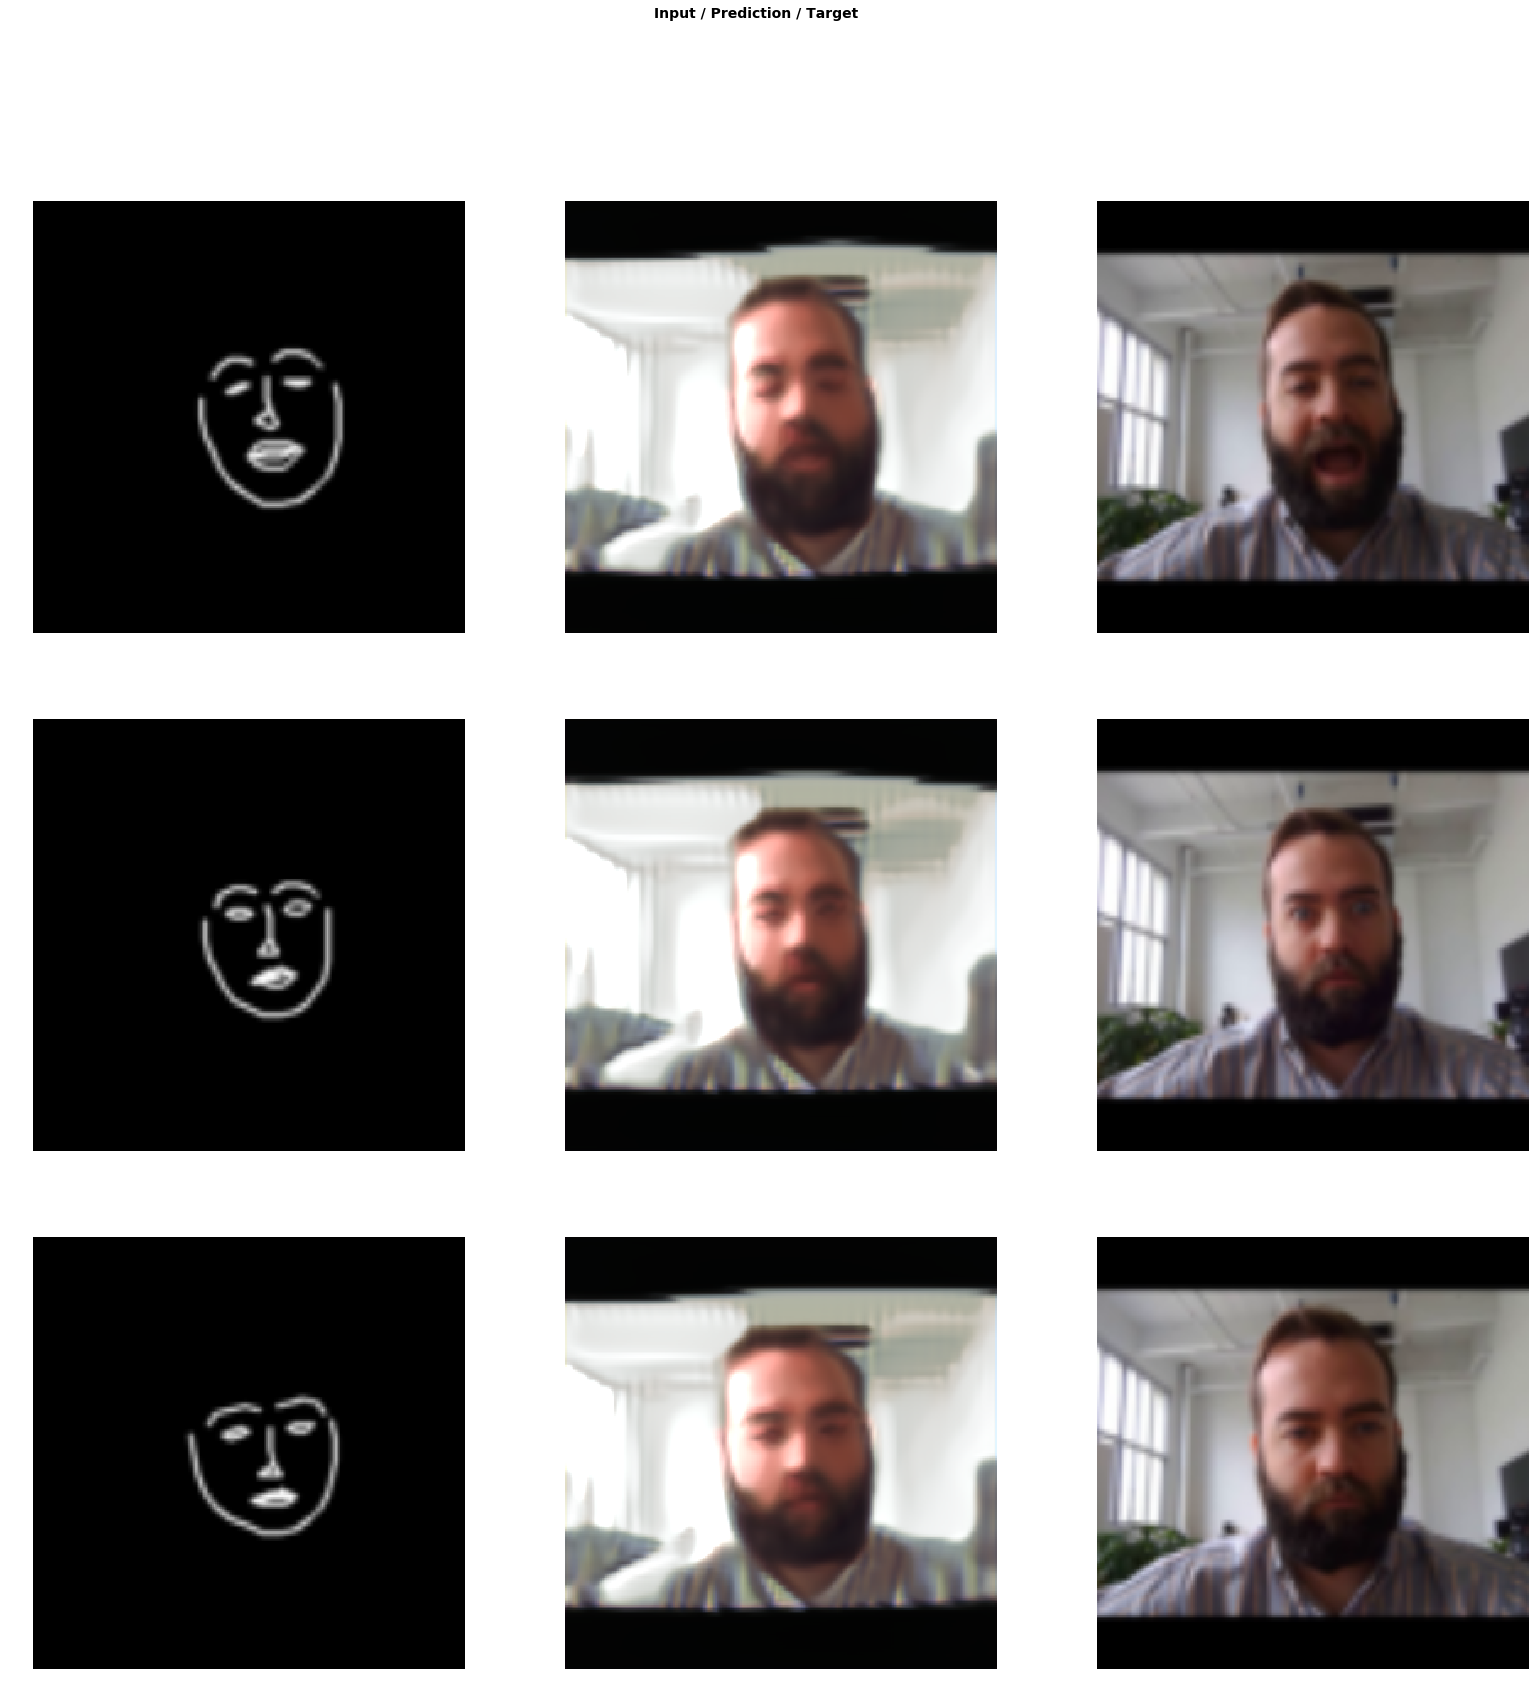

In [13]:
learn.show_results(rows=3, imgsize=9)

create a databunch w/ same transforms from fnames for face datapoints and predict off them

In [14]:
fnames = get_image_files(path_land_mr) #check_ext=True is default
fnames[:5]

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/304.png'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/340.png'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/367.png'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/17.png'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/332.png')]

In [15]:
#regex for pulling out 0-500
np.random.seed(2)
pat = r'(\d+).png$'

In [16]:
fnames[0]

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/304.png')

In [17]:
get_lbl = lambda x: x.stem

In [18]:
fnames[0].stem

'304'

In [19]:
tfms = get_transforms(do_flip=False, max_rotate=0.0, max_zoom=0.0, max_lighting=0.0, max_warp=0.0)

In [20]:
size = 256

In [21]:
# data_lands = ImageDataBunch.from_name_re(path_land_mr, fnames, pat, ds_tfms=tfms, size=size)
data_lands = ImageDataBunch.from_name_func(path_land_mr, 
                                           fnames, 
                                           label_func=get_lbl, 
                                           valid_pct=0.0, 
                                           dl_tfms=tfms, 
                                           size=size)

In [22]:
data_lands.x[0].shape, data_lands.x[0].data

(torch.Size([3, 256, 341]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

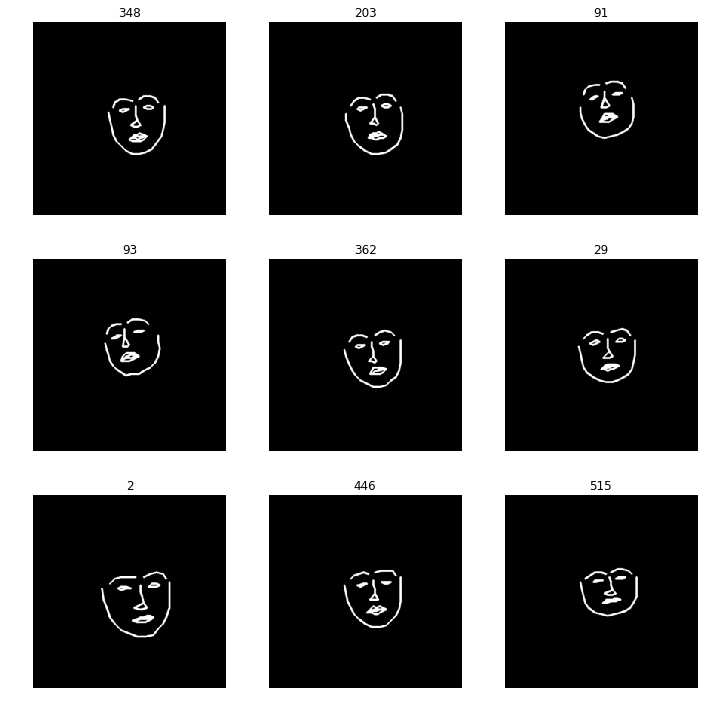

In [23]:
data_lands.show_batch(rows=3, figsize=(10,10)) 

In [120]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img = mpimg.imread('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/304.png')
# plt.imshow(img)
# plt.show()


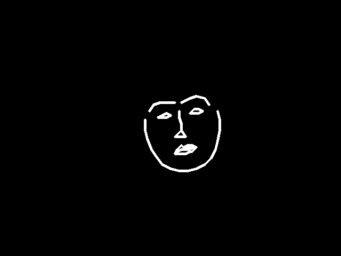

In [24]:
data_lands.x[4]

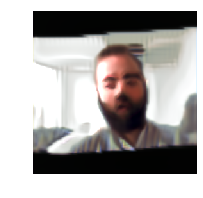

In [25]:
show_image(learn.predict(data_lands.x[0])[0])

In [26]:
data_lands.x

ImageList (540 items)
Image (3, 256, 341),Image (3, 256, 341),Image (3, 256, 341),Image (3, 256, 341),Image (3, 256, 341)
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256

In [27]:
y_hat_1 = []
for image in data_lands.x: 
#     print(image)
    y_hat_1.append(learn.predict(image)[1]) #.predict() outputs 3, (4 w return x flag), 1-idx is the prediction, 2idx is raw

Write off predictions so can be played w/ separately. Have them overwrite

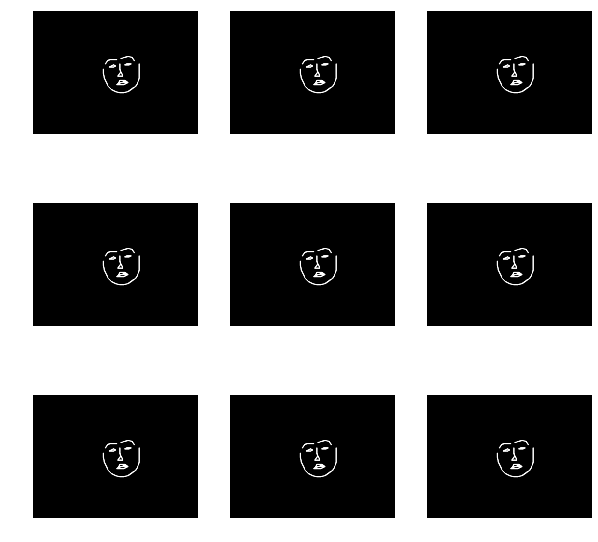

In [28]:
# Double check transforms not occurring 
def _plot(i,j,ax): data_lands.x[0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(10,10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


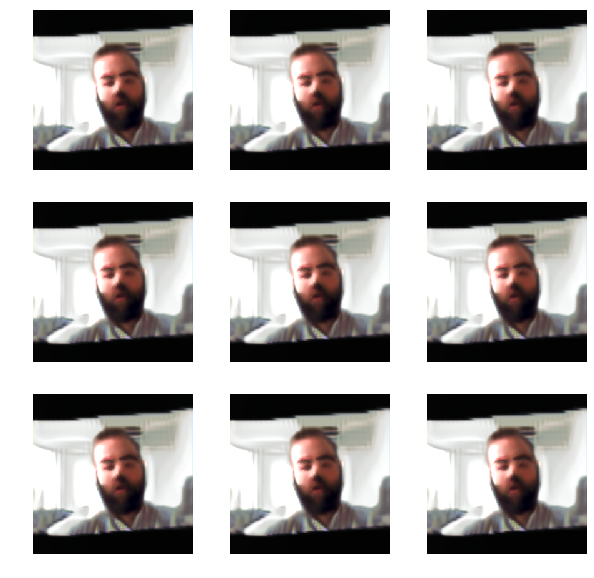

In [29]:
# Double check transforms not occurring 
# def _plot(i,j,ax): data_lands.x[0].show(ax, cmap='gray')
def _plot(i,j,ax): show_image(y_hat_1[0], ax)
plot_multi(_plot, 3, 3, figsize=(10,10))

# Inferences w/ a loop
Lazy but effective. Not sure how to maintain chronology w/ a data_block

In [46]:
path_land_mr

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256')

In [81]:
y_hat = []

for fn in range(1, len(path_land_mr.ls())+1):
    img_path = r'' + str(path_land_mr) + f'/{fn}.png'
    img = open_image(img_path)
    y_hat.append(learn.predict(img)[1])
    if fn % 100 == 0: 
        print (img_path)


/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/100.png
/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/200.png
/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/300.png
/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/400.png
/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/landmarks-256/500.png


In [87]:
y_hat[0].shape

torch.Size([3, 256, 256])

# Img Preprocessing for Video
----
`y_hat_1` has all the predictions. Now to combined them

In [63]:
import torch.nn.functional as F

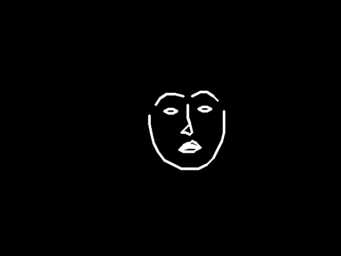

In [77]:
# y_hat[0][0].shape
# learn.predict(img)
img

In [89]:
y_hat[0].shape

torch.Size([3, 256, 256])

In [90]:
w,h = 640, 480
w1, h1 = (640-256)//2, (480-256)//2


In [91]:
# torch.zeros??
z1 = torch.zeros([3, h1, 256])
z2 = torch.zeros([3, h, w1])
z1.shape, z2.shape

(torch.Size([3, 112, 256]), torch.Size([3, 480, 192]))

In [111]:
y_hat[0].min(), y_hat[0].max()

(tensor(-0.0650), tensor(1.2855))

In [112]:
# pad 0's so can export as video (codec has a required aspect ratio)
y_t = []
for y in y_hat:
    y = torch.cat((z1, torch.clamp(y, min=0, max=1), z1), 1)
    y = torch.cat((z2, y, z2), 2)
    y_t.append(y)

In [96]:
# x = F.relu(y_t[0])

In [114]:
#og shape is (3,256,256) and is rgb, cv2 expects (640,480,3) and bgr
# just going to pad w/ 0s to get to 640x480
y_hat_bgr_formatted = [(img.permute(1,2,0)[:,:,[2,1,0]]*255).int().numpy().astype('uint8') for img in y_t]


y_hat_bgr_formatted[0].shape

(480, 640, 3)

In [115]:
y_hat_bgr_formatted[0].min(), y_hat_bgr_formatted[0].max()

(0, 255)

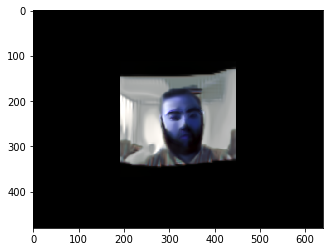

In [116]:
# plt.imshow(y_hat_bgr_formatted[0])
plt.imshow(y_hat_bgr_formatted[0])

In [233]:
# transform.resize??
# y_t = transform.resize(y_hat_bgr_formatted[0], (640,480))


# Combine Into Video

In [117]:
frames_number = len(y_hat_bgr_formatted)
frames_number

540

In [118]:
height, width, layers = y_hat_bgr_formatted[0].shape[:]
height, width, layers

(480, 640, 3)

# fin

In [375]:
writer.isOpened()

True

In [119]:
import cv2
import numpy as np

fn = 'FirstFace'

fn_full = f'/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/images/KrisFace/{fn}.avi'

writer = cv2.VideoWriter(fn_full, cv2.VideoWriter_fourcc('M','P','4','V'),25,(640,480))

for i in range(len(y_hat_bgr_formatted)):
    x = y_hat_bgr_formatted[i]
#     x = x.reshape(480, 640, 3)
    writer.write(x)

In [120]:
writer.isOpened()

True

In [121]:
cv2.destroyAllWindows()
writer.release()